In [1]:
import torch
import torch.nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines import AalenAdditiveFitter

from sksurv.ensemble import RandomSurvivalForest

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

import torchtuples as tt

from auton_survival.models.dsm import DeepSurvivalMachines

from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [2]:
# Import Data
flchain = pd.read_csv("resources/other_data/FLCHAIN.csv")
# nwtco = pd.read_csv("resources/other_data/NWTCO.csv")
# whas = pd.read_excel("resources/other_data/whas.xlsx")
# gbsg = pd.read_csv("resources/other_data/gbsg.csv")
# metabric = pd.read_csv("resources/other_data/METABRIC_RNA_Mutation.csv" , low_memory = False)

--------------

In [3]:
def train_test_splitter(df , test_size = 0.2 , val_size = 0.2 , duration_col = 'futime' , event_col = 'death'):
    df_test = df.sample(frac=test_size)
    df_train = df.drop(df_test.index)

    df_val = df_train.sample(frac=val_size)
    df_train = df_train.drop(df_val.index)

    return df_train , df_val , df_test

------------
## **FLCHAIN**

In [4]:
flchain.head(2)

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.70,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.87,0.683,1,0.9,0,1281,1,Neoplasms


## **<font color='red'>DO NOT DO SCALING/ ENCODING ON ENTIRE DATASET!</font>**

In [5]:
# Create an instance of the OneHotEncoder class
encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
scaler = StandardScaler()

# Fit and transform the data
encoded_sex_data = encoder1.fit_transform(flchain['sex'])
encoded_sex_data = pd.DataFrame(encoded_sex_data.reshape(-1 , 1) , columns = ['sex']) 
print(f'encoded_sex_data.shape {encoded_sex_data.shape}')

# Fit and transform the data
encoded_chap_data = encoder2.fit_transform(flchain['chapter'])
encoded_chap_data = pd.DataFrame(encoded_chap_data.reshape(-1 , 1) , columns = ['chapter'])
print(f'encoded_chap_data.shape {encoded_chap_data.shape}')

scaled_data = pd.DataFrame(scaler.fit_transform(flchain[['age' , 'sample.yr' , 'kappa' , 'lambda' , 'flc.grp' , 'creatinine' , 'mgus']]) , 
                           columns = ['age' , 'sample.yr' , 'kappa' , 'lambda' , 'flc.grp' , 'creatinine' , 'mgus']
)
print(f'scaled_data.shape {scaled_data.shape}')

flchain_mod = pd.DataFrame(pd.concat([encoded_sex_data , encoded_chap_data , scaled_data , flchain[['futime' , 'death']]] , axis = 1))

print(f'flchain_mod.shape {flchain_mod.shape}')

encoded_sex_data.shape (7874, 1)
encoded_chap_data.shape (7874, 1)
scaled_data.shape (7874, 7)
flchain_mod.shape (7874, 11)


In [6]:
df_train , df_test , df_val = train_test_splitter(flchain_mod)

# Create an instance of the SimpleImputer class
train_imputer = SimpleImputer(strategy='mean')
test_imputer = SimpleImputer(strategy='mean')
val_imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
df_train_imp = pd.DataFrame(train_imputer.fit_transform(df_train) , columns = df_train.columns)
df_test_imp = pd.DataFrame(test_imputer.fit_transform(df_test) , columns = df_test.columns)
df_val_imp = pd.DataFrame(val_imputer.fit_transform(df_val) , columns = df_val.columns)

#### **Non-Param**

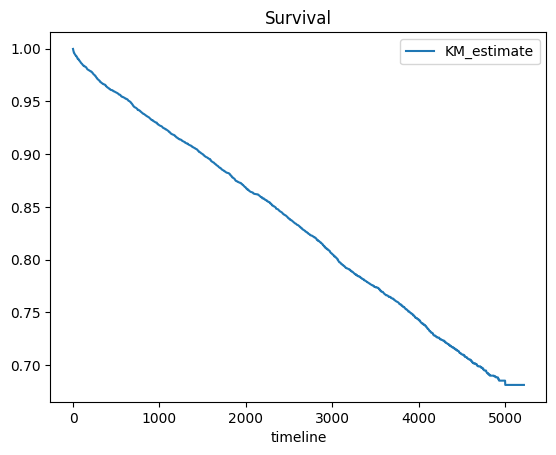

In [7]:
kmf = KaplanMeierFitter()

T = flchain["futime"]
E = flchain["death"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot()
plt.title('Survival');

<Axes: xlabel='timeline'>

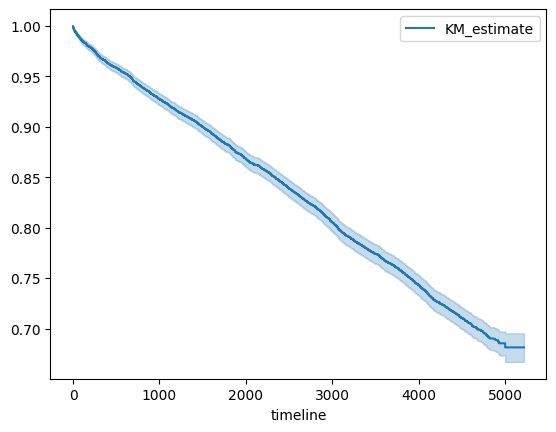

In [8]:
kmf.plot_survival_function()

<Axes: xlabel='timeline'>

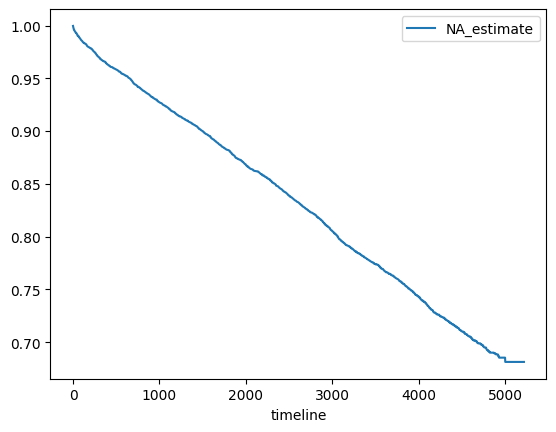

In [9]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
# print(naf.cumulative_hazard_.head())
# naf.plot_cumulative_hazard()
np.exp(-naf.cumulative_hazard_).plot()
# naf.plot_survival_function()

#### **Semi Param**

In [10]:
cph = CoxPHFitter()
cph.fit(df_train_imp, duration_col='futime', event_col='death')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5039 total observations, 3667 right-censored observations>
             duration col = 'futime'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 5039
number of events observed = 1372
   partial log-likelihood = -9790.81
         time fit was run = 2023-07-10 11:04:24 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
sex          0.18       1.19       0.06             0.06             0.29                 1.07                 1.34
chapter     -0.18       0.84       0.00            -0.19            -0.17                 0.83                 0.85
age          0.56       1.75       0.03             0.49             0.63                 1.64                 1.88
sample.yr    0.21       1.23       0.04             0.14             0.28                 1.15                 1.33
kappa        0.00       1.00       0.04            -0.07             0.08                 0.93                 1.08
lambda       0.16       1.18       0.03             0.10             0.22                 1.11                 1.25
flc.grp      0.08       1.09       0.04             0.01             0.16                 1.01                 1.17
creatinine  -0.00       1.00       0.03            -0.06             0.05                 0.95                 1.05
mgus        -0.04       0.96       0.05            -0.13             0.05                 0.88                 1.06

             cmp to      z      p   -log2(p)
covariate                                   
sex            0.00   3.08 <0.005       8.92
chapter        0.00 -35.82 <0.005     930.81
age            0.00  16.23 <0.005     194.47
sample.yr      0.00   5.71 <0.005      26.42
kappa          0.00   0.08   0.94       0.09
lambda         0.00   5.19 <0.005      22.17
flc.grp        0.00   2.25   0.02       5.37
creatinine     0.00  -0.12   0.91       0.14
mgus           0.00  -0.78   0.43       1.21
---
Concordance = 0.90
Partial AIC = 19599.61
log-likelihood ratio test = 3074.99 on 9 df
-log2(p) of ll-ratio test = inf

In [11]:
cph_strat = CoxPHFitter()
cph_strat.fit(df_train_imp, duration_col='futime', event_col='death' , strata=['sex'])
cph_strat.print_summary()

<lifelines.CoxPHFitter: fitted with 5039 total observations, 3667 right-censored observations>
             duration col = 'futime'
                event col = 'death'
                   strata = sex
      baseline estimation = breslow
   number of observations = 5039
number of events observed = 1372
   partial log-likelihood = -8843.48
         time fit was run = 2023-07-10 11:04:24 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
chapter     -0.18       0.84       0.00            -0.19            -0.17                 0.83                 0.85
age          0.56       1.75       0.03             0.49             0.63                 1.64                 1.88
sample.yr    0.21       1.23       0.04             0.14             0.28                 1.15                 1.32
kappa       -0.00       1.00       0.04            -0.08             0.07                 0.93                 1.08
lambda       0.16       1.18       0.03             0.10             0.22                 1.11                 1.25
flc.grp      0.09       1.09       0.04             0.01             0.16                 1.01                 1.17
creatinine  -0.00       1.00       0.03            -0.05             0.05                 0.95                 1.05
mgus        -0.03       0.97       0.05            -0.12             0.06                 0.88                 1.06

             cmp to      z      p   -log2(p)
covariate                                   
chapter        0.00 -35.82 <0.005     930.81
age            0.00  16.19 <0.005     193.32
sample.yr      0.00   5.69 <0.005      26.22
kappa          0.00  -0.02   0.98       0.02
lambda         0.00   5.22 <0.005      22.42
flc.grp        0.00   2.33   0.02       5.67
creatinine     0.00  -0.04   0.97       0.04
mgus           0.00  -0.74   0.46       1.13
---
Concordance = 0.90
Partial AIC = 17702.96
log-likelihood ratio test = 3067.48 on 8 df
-log2(p) of ll-ratio test = inf

<Axes: >

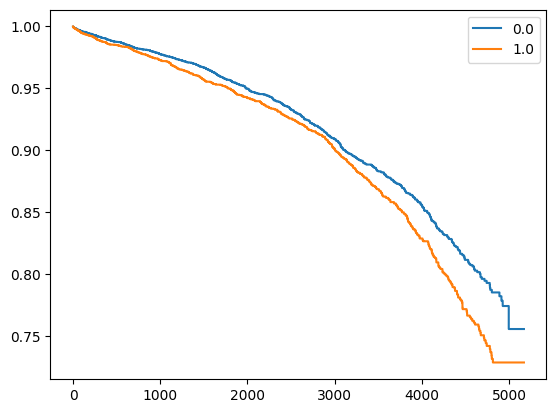

In [12]:
cph_strat.baseline_survival_.plot(drawstyle = 'steps')
# cph_strat.baseline_cumulative_hazard_.plot(drawstyle="steps")

In [13]:
aaf = AalenAdditiveFitter()
aaf.fit(df_train_imp, duration_col='futime', event_col='death')
aaf.predict_median(df_train_imp)
aaf.print_summary()

<lifelines.AalenAdditiveFitter: fitted with 5039 total observations, 3667 right-censored observations>
             duration col = 'futime'
                event col = 'death'
       number of subjects = 5039
number of events observed = 1372
         time fit was run = 2023-07-10 11:04:25 UTC

---
Empty DataFrame
Columns: []
Index: [sex, chapter, age, sample.yr, kappa, lambda, flc.grp, creatinine, mgus, Intercept]
---
Concordance = 0.86

<Axes: >

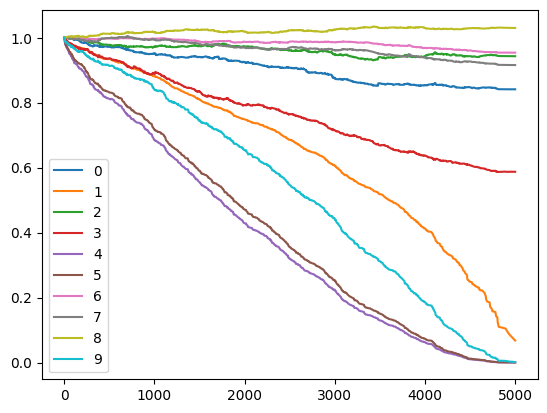

In [37]:
surv = aaf.predict_cumulative_hazard(df_test_imp)
np.exp(-surv.iloc[: , :10]).plot()

#### **Param**

In [14]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter()
eps = 1e-8
df_train_imp['futime'] = df_train_imp['futime'] + eps
aft.fit(df_train_imp, duration_col='futime', event_col='death')

aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 5039 total observations, 3667 right-censored observations>
             duration col = 'futime'
                event col = 'death'
   number of observations = 5039
number of events observed = 1372
           log-likelihood = -12977.596
         time fit was run = 2023-07-10 11:04:26 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                          
lambda_ age        -0.429      0.651      0.029           -0.485           -0.373                0.616                0.689
        chapter     0.133      1.142      0.005            0.124            0.142                1.132                1.153
        creatinine  0.002      1.002      0.022           -0.041            0.045                0.960                1.046
        flc.grp    -0.056      0.946      0.030           -0.115            0.003                0.892                1.003
        kappa      -0.003      0.997      0.030           -0.063            0.056                0.939                1.058
        lambda     -0.130      0.878      0.025           -0.180           -0.081                0.835                0.922
        mgus        0.030      1.030      0.037           -0.043            0.103                0.958                1.108
        sample.yr  -0.098      0.907      0.029           -0.154           -0.041                0.857                0.959
        sex        -0.135      0.873      0.047           -0.227           -0.044                0.797                0.957
        Intercept   7.918   2745.353      0.059            7.802            8.033             2446.538             3080.666
rho_    Intercept   0.210      1.234      0.024            0.163            0.257                1.177                1.293

                     cmp to       z       p   -log2(p)
param   covariate                                     
lambda_ age           0.000 -14.996 <0.0005    166.450
        chapter       0.000  28.212 <0.0005    579.295
        creatinine    0.000   0.091   0.927      0.109
        flc.grp       0.000  -1.868   0.062      4.016
        kappa         0.000  -0.114   0.909      0.137
        lambda        0.000  -5.164 <0.0005     21.979
        mgus          0.000   0.806   0.420      1.251
        sample.yr     0.000  -3.401   0.001     10.543
        sex           0.000  -2.902   0.004      8.077
        Intercept     0.000 134.666 <0.0005        inf
rho_    Intercept     0.000   8.728 <0.0005     58.427
---
Concordance = 0.897
AIC = 25977.191
log-likelihood ratio test = 2868.999 on 9 df
-log2(p) of ll-ratio test = inf

<Axes: >

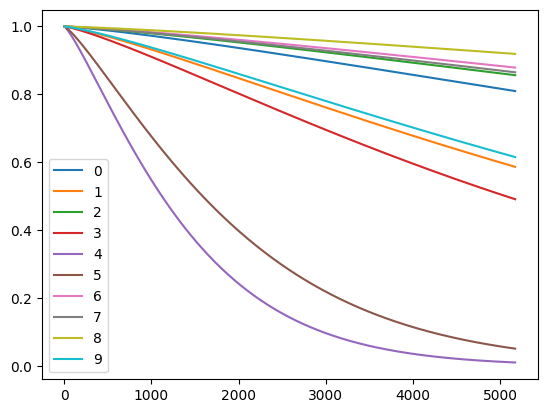

In [15]:
aft.predict_survival_function(df_test_imp.iloc[:10]).plot()

#### **RSF**

In [16]:
# Train
X_train = df_train_imp[['sex', 'chapter', 'age', 'sample.yr', 'kappa', 'lambda', 'flc.grp','creatinine', 'mgus',]]
df_train_imp['death_bool'] = df_train_imp['death'].astype('bool')
y_train = np.rec.array(df_train_imp[['death_bool' , 'futime']].to_records(index=False))

# Test
X_test = df_test_imp[['sex', 'chapter', 'age', 'sample.yr', 'kappa', 'lambda', 'flc.grp','creatinine', 'mgus',]]
df_test_imp['death_bool'] = df_test_imp['death'].astype('bool')
y_test = np.rec.array(df_test_imp[['death_bool' , 'futime']].to_records(index=False))

# Val
X_val = df_val_imp[['sex', 'chapter', 'age', 'sample.yr', 'kappa', 'lambda', 'flc.grp','creatinine', 'mgus',]]
df_val_imp['death_bool'] = df_val_imp['death'].astype('bool')
y_val = np.rec.array(df_val_imp[['death_bool' , 'futime']].to_records(index=False))

In [17]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1234
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=1234)

In [18]:
# Concordance
rsf.score(X_test, y_test)  , rsf.score(X_val, y_val) 

KeyboardInterrupt: 

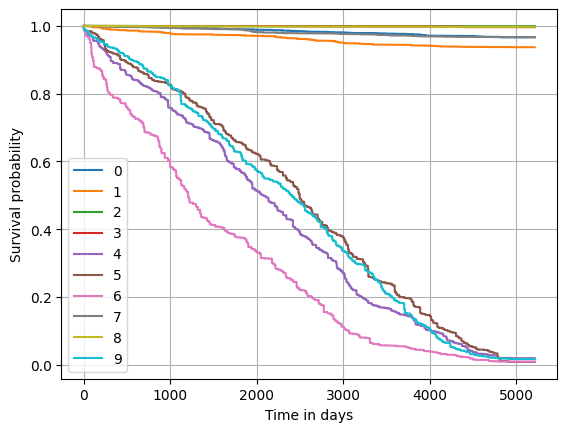

In [ ]:
surv = rsf.predict_survival_function(X_val[:10], return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

#### **PyCox**

In [ ]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['futime'].values, df['death'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (X_train.to_numpy().astype('float32'), y_train)
val = (X_val.to_numpy().astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

0:	[0s / 0s],		train_loss: 3.8454,	val_loss: 2.4754
1:	[0s / 0s],		train_loss: 1.5473,	val_loss: 0.7921
2:	[0s / 0s],		train_loss: 0.7635,	val_loss: 0.6732
3:	[0s / 0s],		train_loss: 0.6640,	val_loss: 0.6355
4:	[0s / 0s],		train_loss: 0.6352,	val_loss: 0.6246
5:	[0s / 0s],		train_loss: 0.6404,	val_loss: 0.6211
6:	[0s / 0s],		train_loss: 0.6242,	val_loss: 0.6067
7:	[0s / 0s],		train_loss: 0.6125,	val_loss: 0.6037
8:	[0s / 0s],		train_loss: 0.6140,	val_loss: 0.6111
9:	[0s / 0s],		train_loss: 0.6089,	val_loss: 0.6014
10:	[0s / 0s],		train_loss: 0.6017,	val_loss: 0.6019
11:	[0s / 0s],		train_loss: 0.5901,	val_loss: 0.5976
12:	[0s / 0s],		train_loss: 0.5869,	val_loss: 0.6086
13:	[0s / 0s],		train_loss: 0.5919,	val_loss: 0.5995
14:	[0s / 0s],		train_loss: 0.5913,	val_loss: 0.5985
15:	[0s / 0s],		train_loss: 0.5854,	val_loss: 0.5955
16:	[0s / 0s],		train_loss: 0.5865,	val_loss: 0.5987
17:	[0s / 0s],		train_loss: 0.5831,	val_loss: 0.6010
18:	[0s / 0s],		train_loss: 0.5786,	val_loss: 0.5950
19:

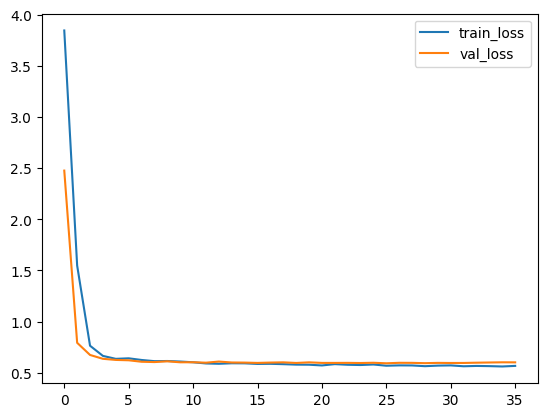

In [ ]:
in_features = X_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(X_train.to_numpy().astype('float32'), y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

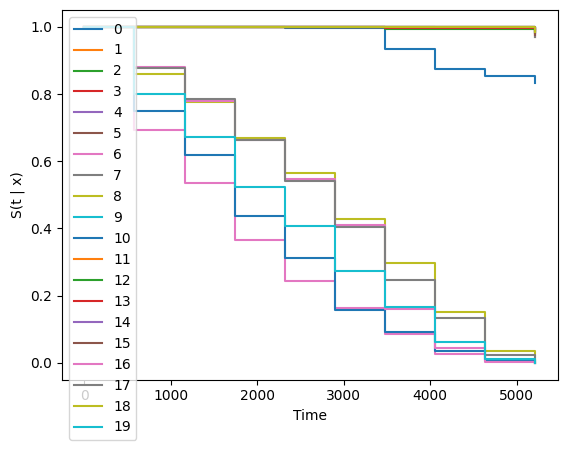

In [ ]:
surv = model.predict_surv_df(X_test.to_numpy().astype('float32'))

surv.iloc[:, :20].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

shapes : (1260, 1260, 1260, 1260)
td-concordance 0.9275975595022351
integrated brier score 0.045251927512677294


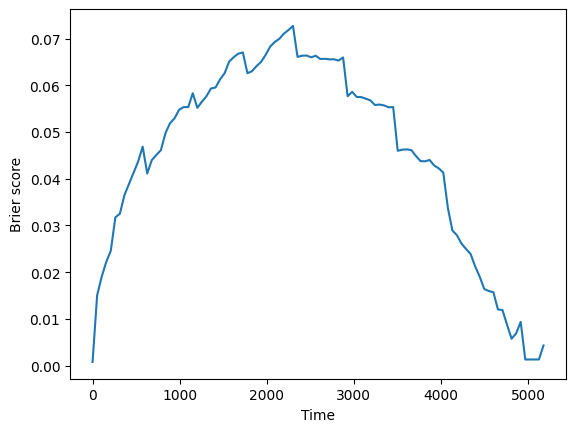

In [ ]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **Deep Survival Machines**

In [ ]:
param_grid = {'k' : [3],
              'distribution' : ['Weibull'],
              'learning_rate' : [1e-4],
              'layers' : [ [100, 100] ]
             }
params = ParameterGrid(param_grid)

# choose model
models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(X_train.to_numpy(), y_train[0], y_train[1].astype('int64'), iters = 100, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(X_val.to_numpy(), y_val[0], y_val[1].astype('int64')), model]])
    print(model.compute_nll(X_val.to_numpy(), y_val[0], y_val[1].astype('int64')))
best_model = min(models)
model = best_model[0][1]

100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


nan


In [ ]:
horizons = [0.25, 0.5, 0.75]
times = np.quantile(flchain_mod['futime'][flchain_mod['death']==1], horizons).tolist()

out_risk = model.predict_risk(X_test.to_numpy(), times)
out_survival = model.predict_survival(X_test.to_numpy(), times)

out_risk

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

In [ ]:
cis = []
brs = []

et_train = np.array([(y_train[1][i], y_train[0][i]) for i in range(len(y_train[1]))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(y_test[1][i], y_test[0][i]) for i in range(len(y_test[1]))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(y_val[1][i], y_val[0][i]) for i in range(len(y_val[1]))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

ValueError: Input estimate contains NaN.

In [ ]:
from auton_survival import datasets
outcomes, features = datasets.load_support()

from auton_survival.preprocessing import Preprocessor
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
	     'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

features = Preprocessor().fit_transform(features, cat_feats=cat_feats, num_feats=num_feats)

import numpy as np
horizons = [0.25, 0.5, 0.75]
times = np.quantile(outcomes.time[outcomes.event==1], horizons).tolist()

x, t, e = features.values.astype('float32'), outcomes.time.values, outcomes.event.values # had to add the type changing

n = len(x)

tr_size = int(n*0.70)
vl_size = int(n*0.10)
te_size = int(n*0.20)

x_train, x_test, x_val = x[:tr_size], x[-te_size:], x[tr_size:tr_size+vl_size]
t_train, t_test, t_val = t[:tr_size], t[-te_size:], t[tr_size:tr_size+vl_size]
e_train, e_test, e_val = e[:tr_size], e[-te_size:], e[tr_size:tr_size+vl_size]

from sklearn.model_selection import ParameterGrid

param_grid = {'k' : [3],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [ 1e-4],
              'layers' : [ [100, 100] ]
             }
params = ParameterGrid(param_grid)

from auton_survival.models.dsm import DeepSurvivalMachines

models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train, t_train, e_train, iters = 100, learning_rate = param['learning_rate'])
    models.append([[model.compute_nll(x_val, t_val, e_val), model]])
best_model = min(models)
model = best_model[0][1]

out_risk = model.predict_risk(x_test.astype('float64'), times) # had to add the type changing
out_survival = model.predict_survival(x_test.astype('float64'), times) # had to add the type changing

from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

cis = []
brs = []

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
et_val = np.array([(e_val[i], t_val[i]) for i in range(len(e_val))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, out_risk[:, i], times[i])[0])
brs.append(brier_score(et_train, et_test, out_survival, times)[1])
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, out_risk[:, i], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[0][horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

 71%|███████   | 71/100 [00:10<00:04,  6.62it/s]

For 0.25 quantile,
TD Concordance Index: 0.7623335943617854
Brier Score: 0.11150376440932878
ROC AUC  0.7695454612224513 

For 0.5 quantile,
TD Concordance Index: 0.7012234504111858
Brier Score: 0.18308459436590344
ROC AUC  0.7222192926949308 

For 0.75 quantile,
TD Concordance Index: 0.6539616512229368
Brier Score: 0.22166510563504155
ROC AUC  0.7063597261767735 



#### **DeepSurv**

In [ ]:
# Numpy Monkey-patch
!pip install numpy==1.20.3

import numpy as np

print(np.__version__)

try:
    np.distutils.__config__.blas_opt_info = np.distutils.__config__.blas_ilp64_opt_info
except Exception:
    pass

import theano

  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [256 lines of output]
      setup.py:66: RuntimeWarning: NumPy 1.20.3 may not yet support Python 3.10.
        warnings.warn(
      Running from numpy source directory.
      setup.py:485: UserWarning: Unrecognized setuptools command, proceeding with generating Cython sources and expanding templates
        run_build = parse_setuppy_commands()
      Cythonizing sources
      Processing numpy/random\_bounded_integers.pxd.in
      Processing numpy/random\bit_generator.pyx
      Processing numpy/random\mtrand.pyx
      Processing numpy/random\_bounded_integers.pyx.in
      Processing numpy/random\_common.pyx
      Processing numpy/random\_generator.pyx
      Processing numpy/random\_mt19937.pyx
      Processing numpy/random\_pcg64.pyx
      Processing numpy/random\_philox.pyx
      Processing numpy/random\_sfc64.pyx
      blas_opt_info:
      blas_mkl_info:
   

  Using cached numpy-1.20.3.zip (7.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'
1.23.5


AttributeError: module 'numpy.distutils.__config__' has no attribute 'blas_opt_info'

In [ ]:
import deep_surv


# from deepsurv_logger import DeepSurvLogger, TensorboardLogger
# import utils
# import viz

# import numpy as np
# import pandas as pd

# import lasagne
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)

In [ ]:
import sys
sys.path
sys.path.append('../deepsurv')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


AttributeError: module 'numpy.distutils.__config__' has no attribute 'blas_opt_info'